# Test symbolic classification on Digen benchmark

- Generative and reproducible benchmarks for comprehensive evaluation of machine learning classifiers [arxiv](https://arxiv.org/pdf/2107.06475.pdf), [github](https://github.com/EpistasisLab/digen)

In [1]:
import numpy as np, pandas as pd
from digen import Benchmark
from HROCH import NonlinearLogisticRegressor
from rils_rols.rils_rols import RILSROLSBinaryClassifier
import matplotlib.pyplot as plt
import seaborn as sns

/home/jano/GECCO2023/SR/classification_test/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jano/GECCO2023/SR/classification_test/test_env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## Run benchmark

In [2]:
# TODO: parameters
RANDOM_STATE = 123
TIME_LIMIT = 1
NUM_THREADS = 1

benchmark=Benchmark()

res_hr = benchmark.evaluate(NonlinearLogisticRegressor(num_threads=NUM_THREADS, time_limit=TIME_LIMIT, random_state=RANDOM_STATE), local_cache_dir="../instances/digen/")
res_rr = benchmark.evaluate(RILSROLSBinaryClassifier(max_fit_calls=1_000_000, max_seconds=TIME_LIMIT, random_state=RANDOM_STATE), local_cache_dir="../instances/digen/")

Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_seconds=1 complexity_penalty=0.001 max_complexity=50 sample_size=1 verbose=False random_state=123
Calling with max_fit_calls=1000000 max_se

## Performance and ranking of the methods across all DIGEN datasets

In [3]:
df1 = pd.DataFrame.from_dict(res_hr).drop('name', axis=1).transpose()
df1['classifier']='HROCH'
df2 = pd.DataFrame.from_dict(res_rr).drop('name', axis=1).transpose()
df2['classifier']='RILS-ROLS'

df_results = pd.concat([df1, df2, benchmark.data]).reset_index()

[Text(0, 0.30000000000000004, '0.3'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.7000000000000001, '0.7'),
 Text(0, 0.8, '0.8'),
 Text(0, 0.9000000000000001, '0.9'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.1, '1.1')]

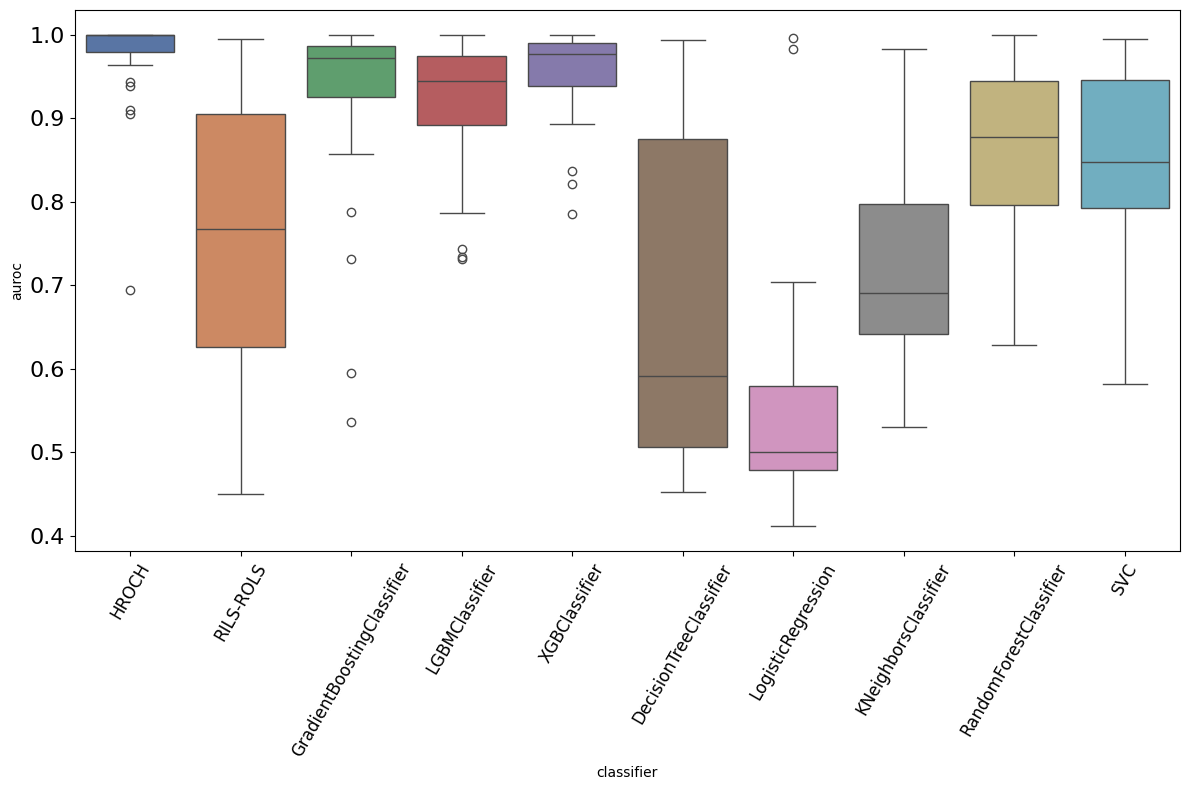

In [4]:
df=df_results[['classifier','dataset','auroc']]
fig,ax = plt.subplots(figsize=(12,8))
ax=sns.boxplot(data=df, x='classifier', y='auroc', ax=ax, palette="deep")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

## Number of victories visualization

A win-lose chart showing how many times a method in row outperformed a method in column by more than 0.001.

<Axes: >

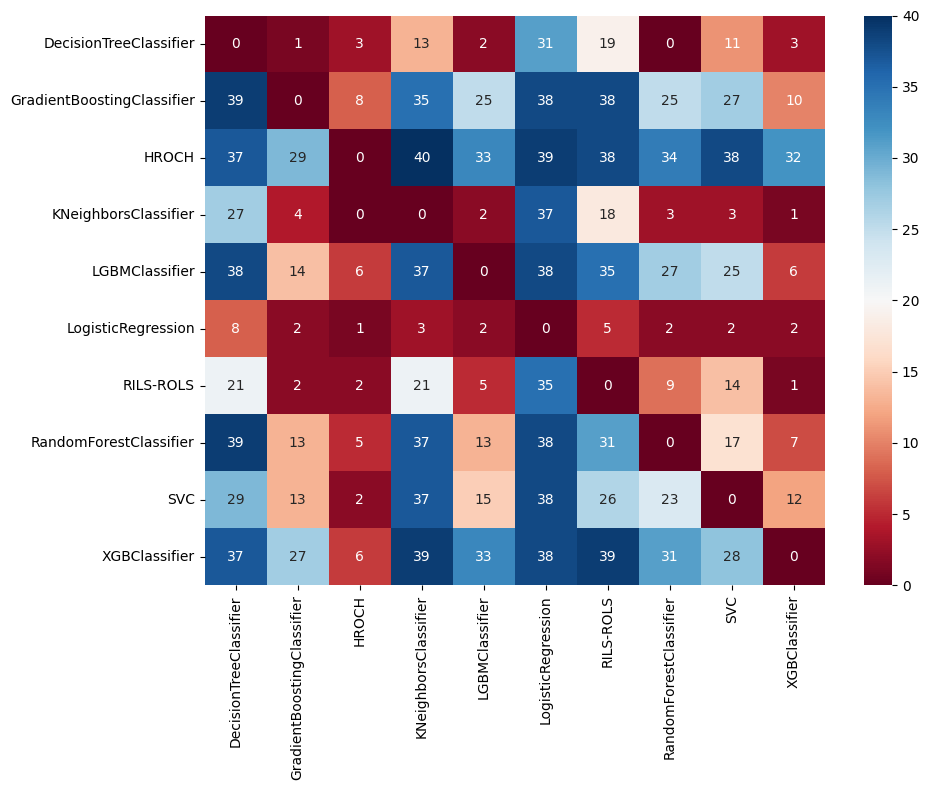

In [5]:
df = df_results.pivot('dataset', columns='classifier', values='auroc')
df = df.astype(float).round(3)
from itertools import product
import seaborn as sns

algorithms = list(df.columns)
wins = pd.DataFrame(index=algorithms, columns=algorithms)

for alg1, alg2 in product(algorithms, algorithms):
    wins.loc[alg1, alg2] = (df[alg1] > df[alg2]).sum()

    
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=wins.astype(int), annot=True, cmap="RdBu")

## ROC curves comparsion

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'ROC Curves Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

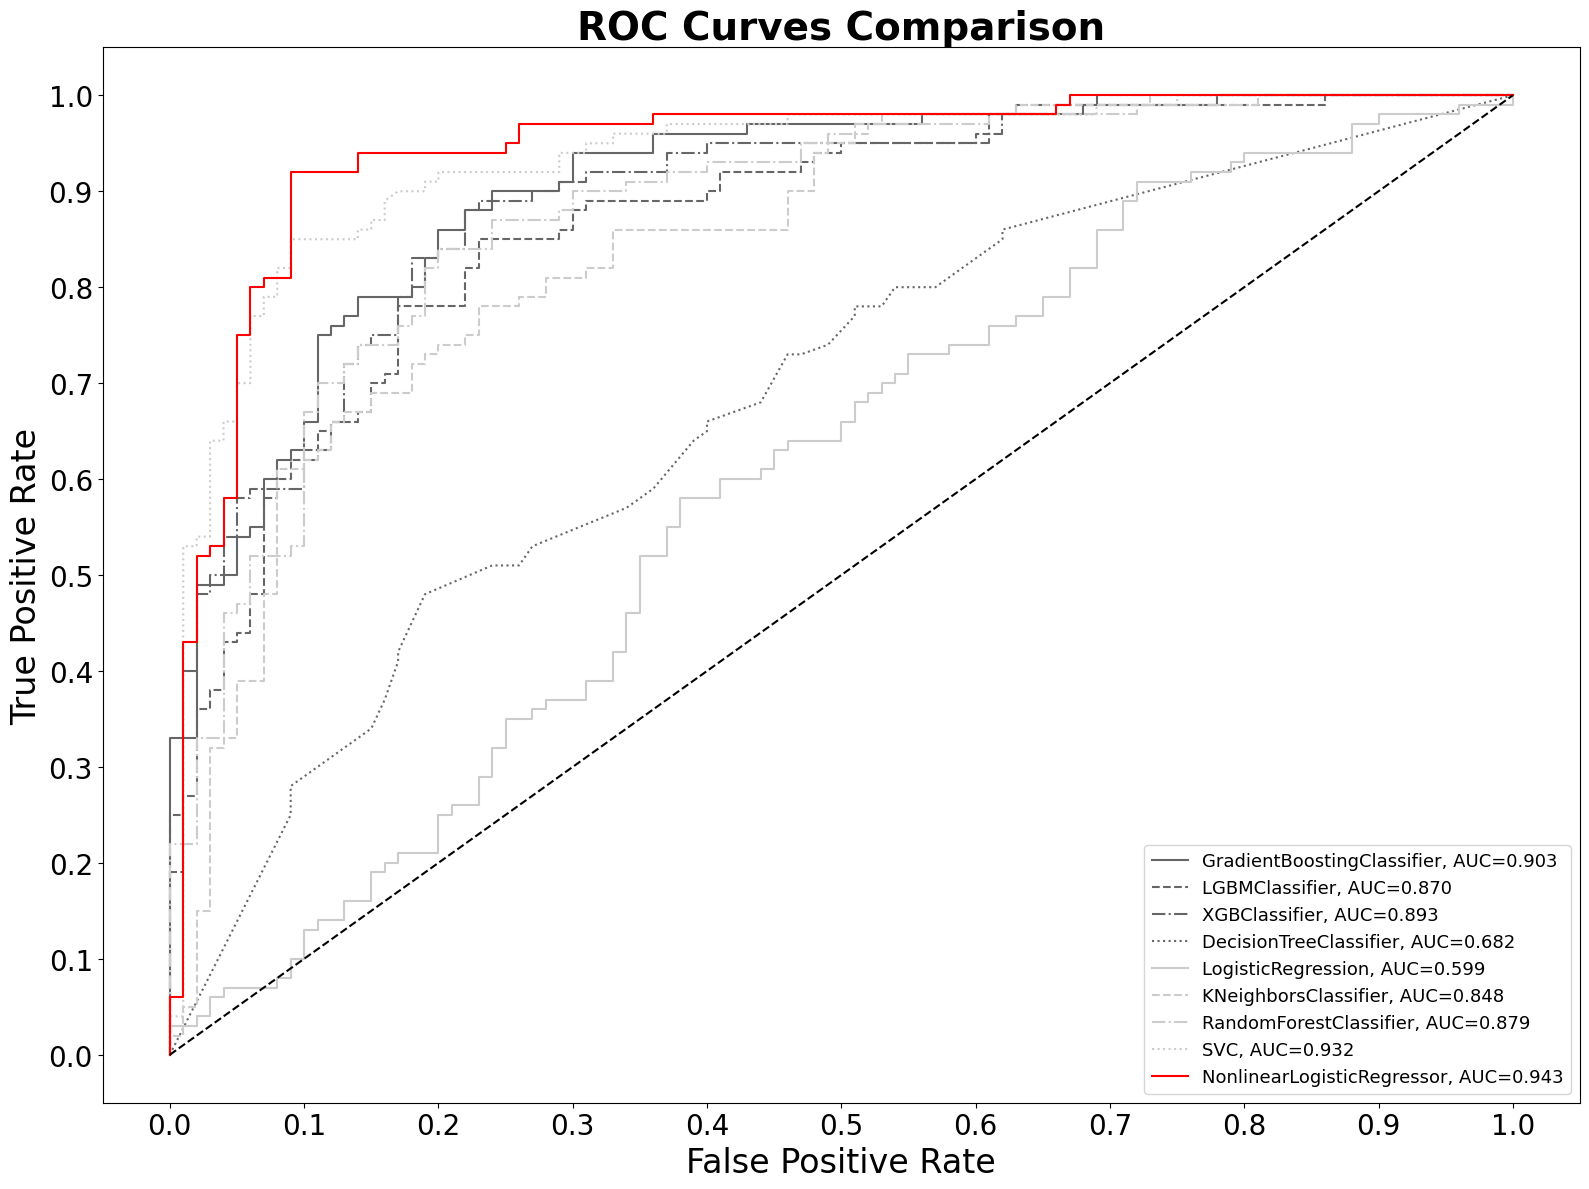

In [6]:
benchmark.plot_roc('digen13_769', new_results=res_hr)

TypeError: cannot pickle 'rils_rols_cpp.rils_rols' object

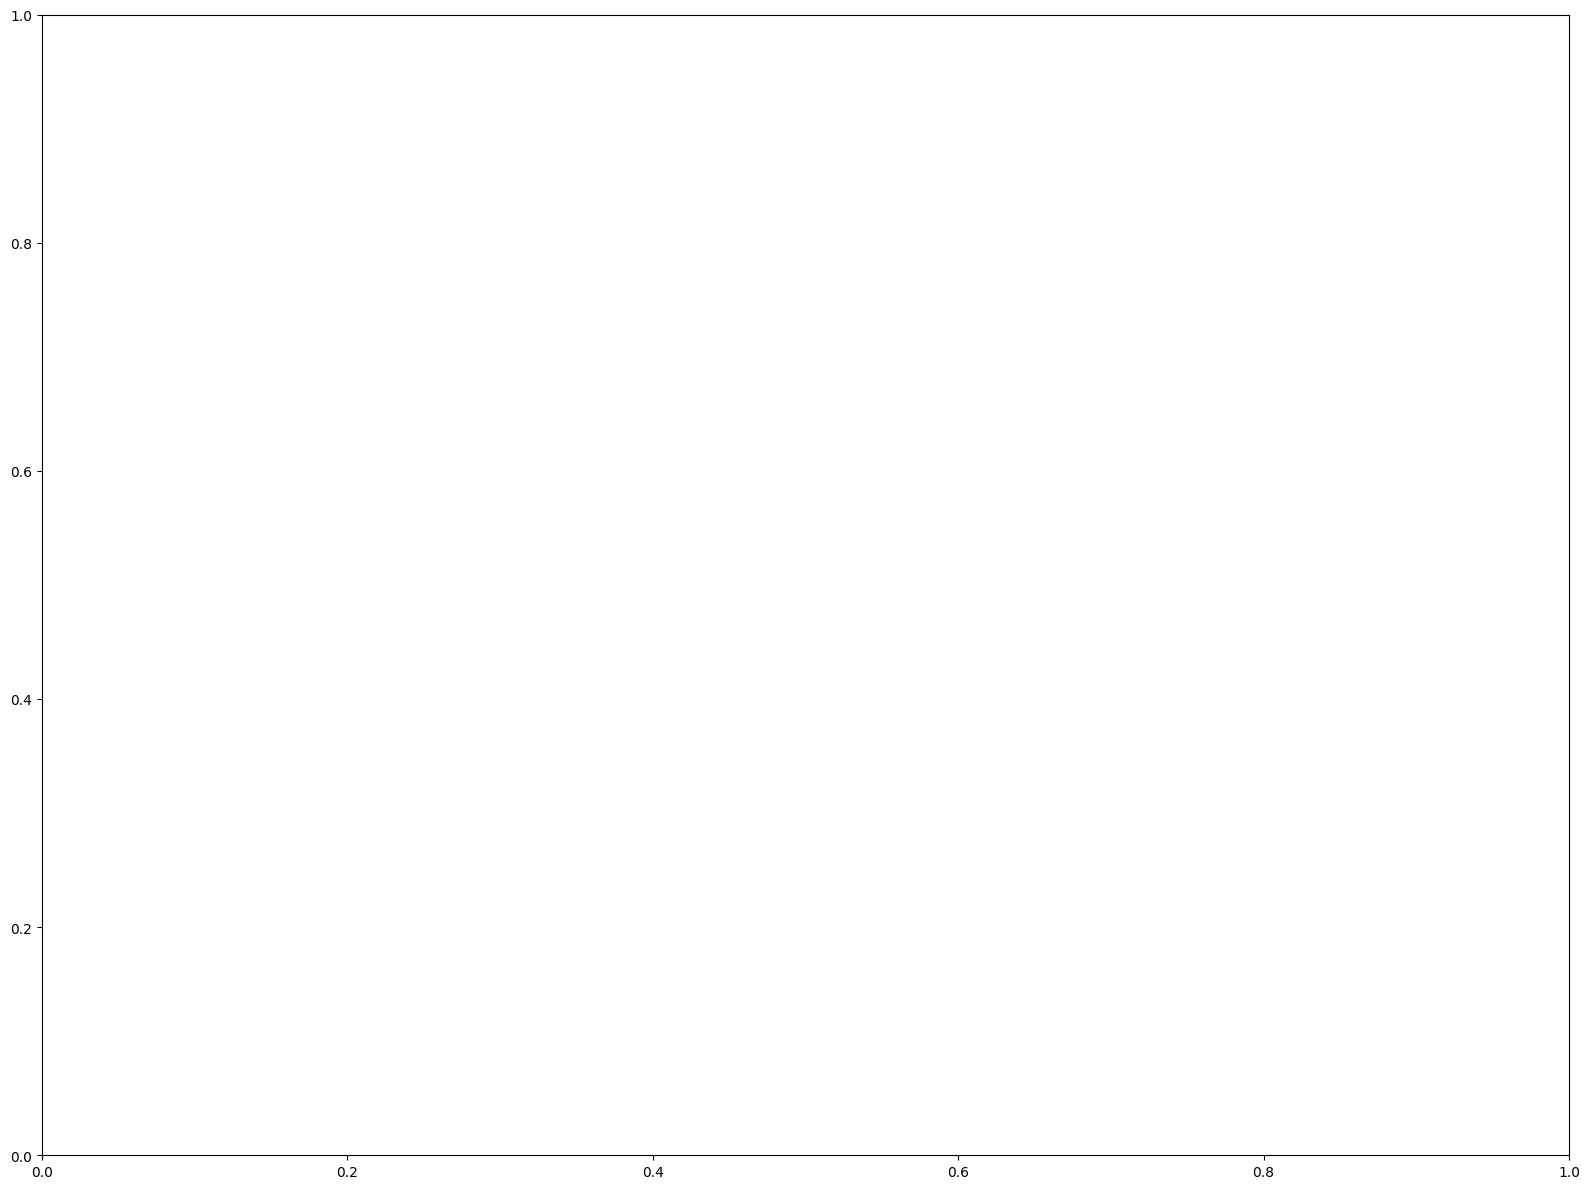

In [7]:
# TODO: TypeError: cannot pickle 'rils_rols_cpp.rils_rols' object
benchmark.plot_roc('digen13_769', new_results=res_rr)